# Классификация Oxford Pets

Обучим сеть для классификации исходного датасета [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Загрузите датасет с Kaggle.

#### Импорт необходимых библиотек


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.image as image
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, Input, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications import ResNet50, VGG16, VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Dense, Flatten, RandomFlip, RandomRotation, Dropout, GlobalAveragePooling2D, Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, ZeroPadding2D, Activation, Add, AveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#### Построение графиков


In [ ]:

def plot_metrics(epochs, metric, val_metric, title, subplot_position):
    plt.subplot(1, 3, subplot_position)
    plt.plot(range(epochs), metric, label='train ' + title.lower())
    plt.plot(range(epochs), val_metric, label='validation ' + title.lower())
    plt.legend(loc='lower right' if 'accuracy' in title else 'upper right')
    plt.title(title)

def show_acc_loss(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(15, 8))
    plot_metrics(epochs, acc, val_acc, 'Accuracy', 1)
    plot_metrics(epochs, loss, val_loss, 'Loss', 2)

    plt.show()

### Загрузка и обработка данных


Для начала загрузим датасет Oxford-IIIT Pet с сайта https://www.robots.ox.ac.uk/~vgg/data/pets/ и подключим google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/AI/images.tar.gz .
!tar xfz images.tar.gz

Выполним приведение изображений к единому размеру, а также создадим словарь для сопоставления меток классов и их числовых индексов

In [ ]:

BASE_PATH = "images"
IMAGE_SIZE = (224, 224)

def get_image_names(base_path):
    return [os.path.basename(file) for file in glob.glob(os.path.join(base_path, '*.jpg'))]

def encode_labels(image_names):
    label_map = {}
    current_label = 0

    for name in image_names:
        label = ' '.join(name.split('_')[:-1])
        if label not in label_map:
            label_map[label] = current_label
            current_label += 1

    return label_map

def load_and_preprocess_images(image_names, base_path, image_size):
    features = []
    labels = []
    label_map = encode_labels(image_names)

    for name in image_names:
        label = ' '.join(name.split('_')[:-1])
        label_encoded = label_map[label]

        img = load_img(os.path.join(base_path, name))
        img = tf.image.resize_with_pad(img_to_array(img, dtype='uint8'), *image_size).numpy().astype('uint8')

        features.append(img)
        labels.append(label_encoded)

    return np.array(features), np.array(labels), label_map

image_names = get_image_names(BASE_PATH)
features, labels, label_map = load_and_preprocess_images(image_names, BASE_PATH, IMAGE_SIZE)

num_classes = len(label_map)
print("Количество пород:", num_classes)
print("Словарь меток:", label_map)

Количество пород: 37
Словарь меток: {'Birman': 0, 'saint bernard': 1, 'havanese': 2, 'keeshond': 3, 'Bengal': 4, 'Bombay': 5, 'newfoundland': 6, 'Abyssinian': 7, 'Persian': 8, 'great pyrenees': 9, 'leonberger': 10, 'miniature pinscher': 11, 'japanese chin': 12, 'scottish terrier': 13, 'Sphynx': 14, 'Russian Blue': 15, 'boxer': 16, 'pug': 17, 'samoyed': 18, 'wheaten terrier': 19, 'Siamese': 20, 'english setter': 21, 'american pit bull terrier': 22, 'Egyptian Mau': 23, 'chihuahua': 24, 'shiba inu': 25, 'english cocker spaniel': 26, 'Maine Coon': 27, 'beagle': 28, 'german shorthaired': 29, 'pomeranian': 30, 'american bulldog': 31, 'yorkshire terrier': 32, 'staffordshire bull terrier': 33, 'basset hound': 34, 'British Shorthair': 35, 'Ragdoll': 36}


Разобьем данные на обучающую и тестовую выборки

In [ ]:
features_arr= np.array(features)
labels_arr = np.array(labels)

labels_one_hot = pd.get_dummies(labels_arr)

X_train, X_test, y_train, y_test = train_test_split(features_arr, labels_one_hot, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

## VGG16


Загрузим базовую модель

In [ ]:
base_vgg16_model = VGG16(weights='imagenet', include_top=False)

base_vgg16_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


Добавим аугментацию данных и верхний слой

In [ ]:
def create_data_augmentation():
    return Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
    ])

def create_vgg16_model(num_classes, base_vgg16_model):
    inputs = Input(shape=(224, 224, 3))

    data_augmentation = create_data_augmentation()
    x = data_augmentation(inputs)

    x = vgg16_preprocess_input(x)

    x = base_vgg16_model(x, training=False)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

vgg16_model = create_vgg16_model(num_classes, base_vgg16_model)


Дообучим модель

In [ ]:
vgg16_model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])
vgg16_history = vgg16_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4)

Epoch 1/4
139/139 [==============================] - 108s 774ms/step - loss: 6.0804 - accuracy: 0.1944 - val_loss: 2.4255 - val_accuracy: 0.5602
Epoch 2/4
139/139 [==============================] - 109s 783ms/step - loss: 3.2671 - accuracy: 0.4073 - val_loss: 1.3437 - val_accuracy: 0.7084
Epoch 3/4
139/139 [==============================] - 108s 781ms/step - loss: 2.5297 - accuracy: 0.4984 - val_loss: 1.1621 - val_accuracy: 0.7395
Epoch 4/4
139/139 [==============================] - 109s 787ms/step - loss: 2.0310 - accuracy: 0.5731 - val_loss: 0.9306 - val_accuracy: 0.7963


Результат обучения

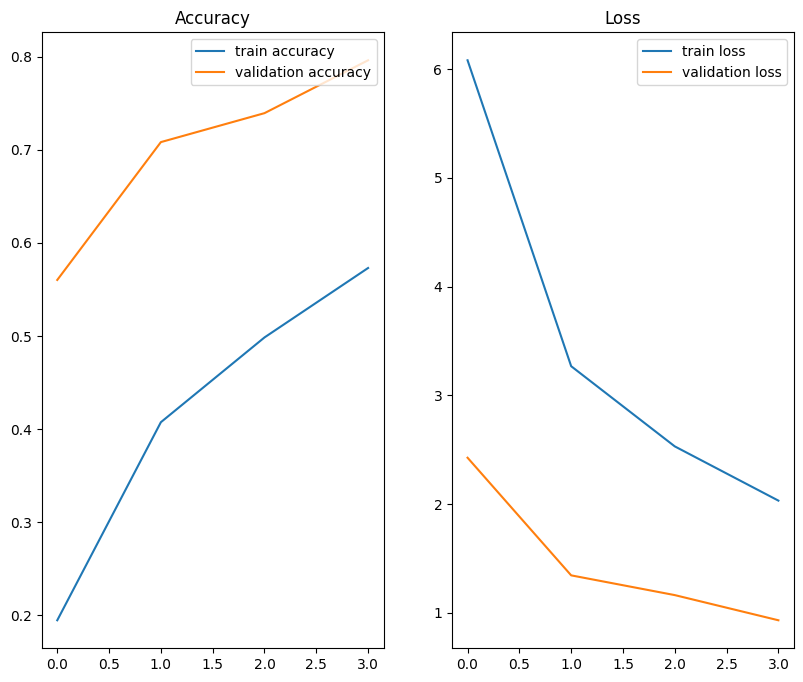

In [ ]:
show_acc_loss(vgg16_history, 4)

In [ ]:
vgg16_model.evaluate(X_test, y_test)

47/47 [==============================] - 27s 568ms/step - loss: 1.0968 - accuracy: 0.7537


[1.096775770187378, 0.7537212371826172]

## VGG19

Загрузим базовую модель

In [ ]:
base_vgg19_model = VGG19(weights='imagenet', include_top=False)

base_vgg19_model.trainable = False

Добавим аугментацию данных и верхний слой

In [ ]:
def create_data_augmentation():
    return Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
    ])

def create_vgg19_model(num_classes, base_model):
    inputs = Input(shape=(224, 224, 3))

    x = create_data_augmentation()(inputs)

    x = vgg19_preprocess_input(x)

    x = base_model(x, training=False)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

vgg19_model = create_vgg19_model(num_classes, base_vgg16_model)

Дообучим модель

In [ ]:
vgg19_model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])
vgg19_history = vgg19_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4)

Epoch 1/4
139/139 [==============================] - 108s 774ms/step - loss: 7.5405 - accuracy: 0.1416 - val_loss: 2.8694 - val_accuracy: 0.4926
Epoch 2/4
139/139 [==============================] - 110s 792ms/step - loss: 3.6727 - accuracy: 0.3705 - val_loss: 1.5121 - val_accuracy: 0.6779
Epoch 3/4
139/139 [==============================] - 109s 785ms/step - loss: 2.7381 - accuracy: 0.4727 - val_loss: 1.1408 - val_accuracy: 0.7382
Epoch 4/4
139/139 [==============================] - 110s 790ms/step - loss: 2.1853 - accuracy: 0.5359 - val_loss: 0.9715 - val_accuracy: 0.7659


Результат обучения

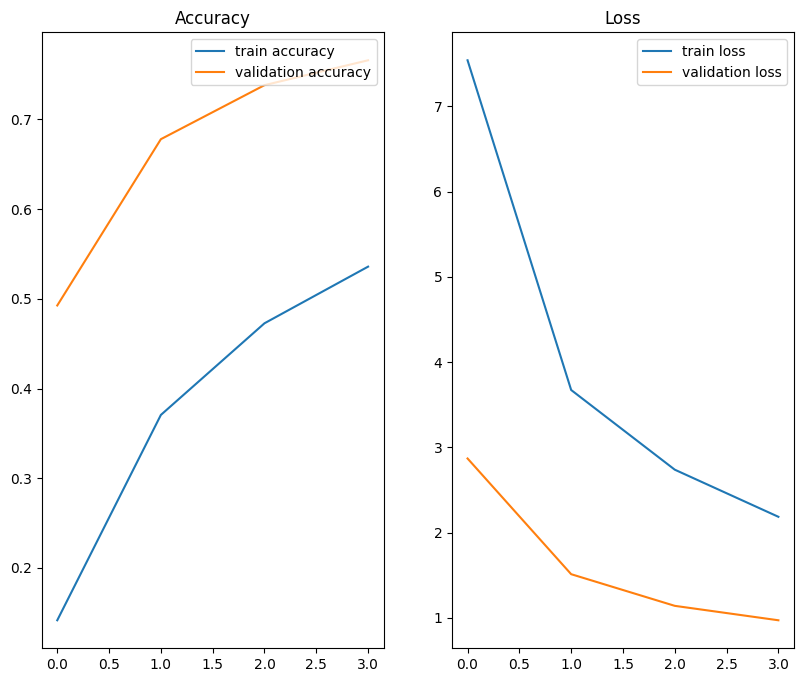

In [ ]:
show_acc_loss(vgg19_history, 4)

In [ ]:
vgg19_model.evaluate(X_test, y_test)

47/47 [==============================] - 27s 576ms/step - loss: 1.1327 - accuracy: 0.7517


[1.1326922178268433, 0.751691460609436]

## ResNet

Загрузим базовую модель

In [ ]:
base_resnet_model = ResNet50(weights='imagenet', include_top=False)

base_resnet_model.trainable = False

Добавим аугментацию данных и верхний слой

In [ ]:
def create_data_augmentation():
    return Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
    ])

def create_resnet_model(num_classes, base_model):
    inputs = Input(shape=(224, 224, 3))

    x = create_data_augmentation()(inputs)

    x = resnet_preprocess_input(x)

    x = base_model(x, training=False)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

resnet_model = create_resnet_model(num_classes, base_resnet_model)

Дообучим модель

In [ ]:
resnet_model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])
resnet_history = resnet_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4)

Epoch 1/4
139/139 [==============================] - 108s 752ms/step - loss: 1.9281 - accuracy: 0.4646 - val_loss: 0.6457 - val_accuracy: 0.8085
Epoch 2/4
139/139 [==============================] - 102s 732ms/step - loss: 0.9316 - accuracy: 0.7172 - val_loss: 0.4481 - val_accuracy: 0.8572
Epoch 3/4
139/139 [==============================] - 104s 751ms/step - loss: 0.7589 - accuracy: 0.7596 - val_loss: 0.4131 - val_accuracy: 0.8613
Epoch 4/4
139/139 [==============================] - 100s 724ms/step - loss: 0.6450 - accuracy: 0.7966 - val_loss: 0.4273 - val_accuracy: 0.8579


Результат обучения

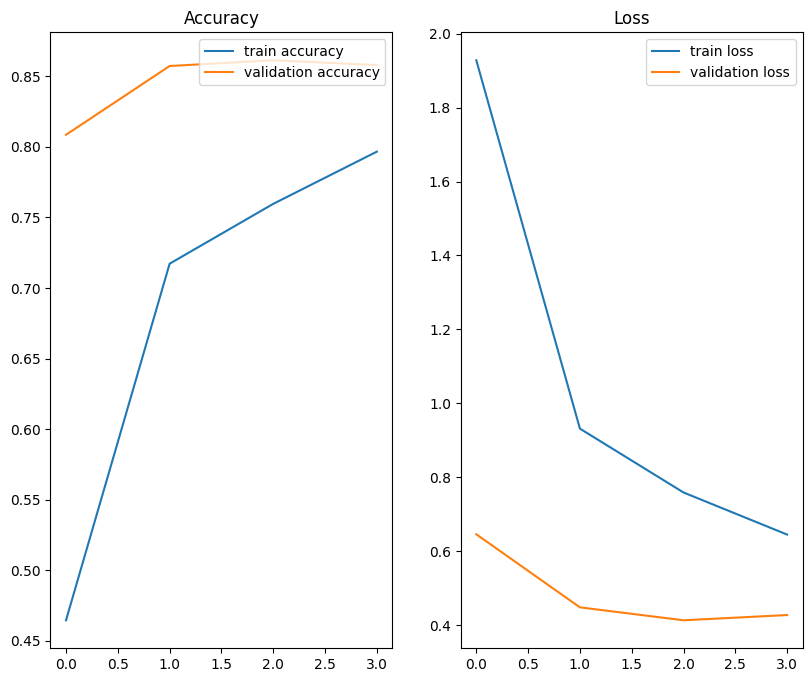

In [ ]:
show_acc_loss(resnet_history, 4)

In [ ]:
resnet_model.evaluate(X_test, y_test)

47/47 [==============================] - 25s 528ms/step - loss: 0.4854 - accuracy: 0.8424


[0.4854382872581482, 0.8423545360565186]

## Лучшая модель

После 4 эпох лучшая точность для датасета The Oxford-IIIT Pet оказалась у ResNet50. На тестовом датасете точность равна 0.8424

#### Точность бинарной классификации

In [ ]:
def compute_binary_accuracy(model, X_test, y_test, threshold=12):
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    binary_true_classes = np.where(true_classes < threshold, 0, 1)
    binary_predicted_classes = np.where(predicted_classes < threshold, 0, 1)

    return accuracy_score(binary_true_classes, binary_predicted_classes)

binary_accuracy = compute_binary_accuracy(resnet_model, X_test, y_test)
print("Точность двоичной классификации (кошки vs собаки):", binary_accuracy)

47/47 [==============================] - 25s 534ms/step
Точность двоичной классификации (кошки vs собаки): 0.9330175913396481


#### Сonfusion matrix

47/47 [==============================] - 25s 537ms/step


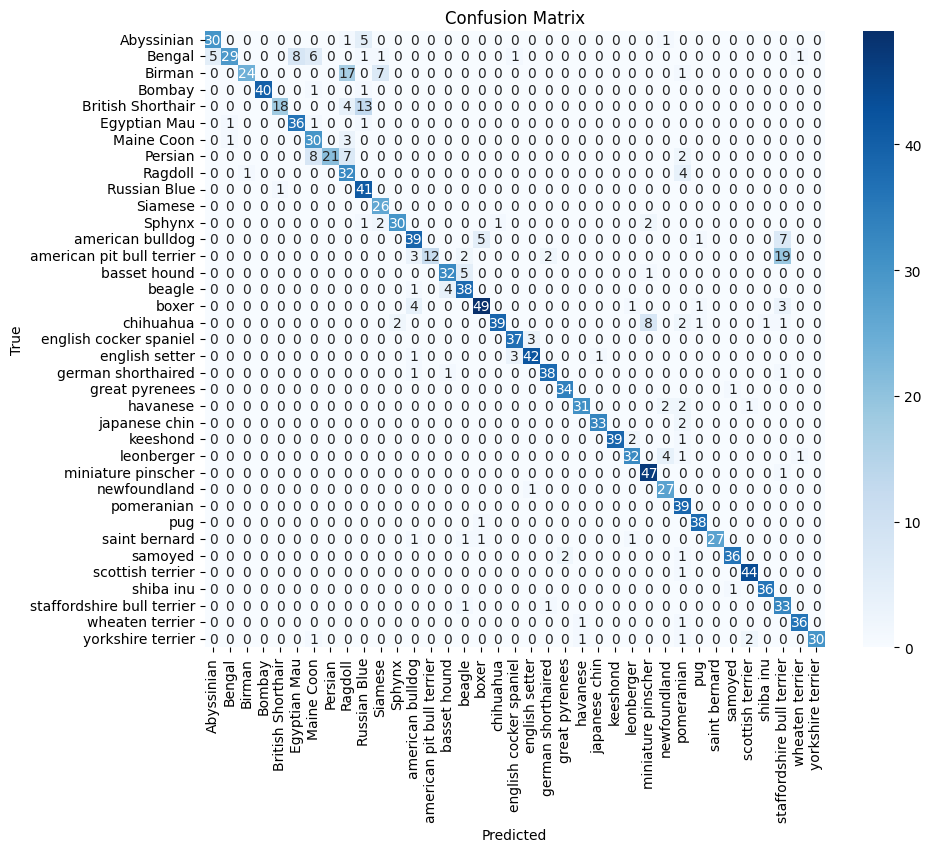

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def get_class_names(predicted_classes, true_classes, label_map):
    reverse_label_map = {v: k for k, v in label_map.items()}

    predicted_class_names = [reverse_label_map[label] for label in predicted_classes]
    true_class_names = [reverse_label_map[label] for label in true_classes]

    return true_class_names, predicted_class_names

def plot_confusion_matrix(true_class_names, predicted_class_names):
    all_labels = np.unique(np.concatenate((true_class_names, predicted_class_names)))
    conf_matrix = confusion_matrix(true_class_names, predicted_class_names, labels=all_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=all_labels, yticklabels=all_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def evaluate_model(model, X_test, y_test, label_map):
    predicted_classes = model.predict(X_test)
    predicted_classes = np.argmax(predicted_classes, axis=1)

    true_classes = np.argmax(y_test, axis=1)

    true_class_names, predicted_class_names = get_class_names(predicted_classes, true_classes, label_map)
    plot_confusion_matrix(true_class_names, predicted_class_names)

evaluate_model(resnet_model, X_test, y_test, label_map)

#### top-3 и top-5 accuracy

In [ ]:

def get_top_n_predictions(predictions, n):
    return np.argsort(predictions, axis=1)[:, -n:][:, ::-1]

def calculate_accuracy(true_classes, pred_classes):
    return np.mean([true_classes[i] in pred_classes[i] for i in range(len(true_classes))])

predictions = resnet_model.predict(X_val)

top3_pred_classes = get_top_n_predictions(predictions, 3)
top5_pred_classes = get_top_n_predictions(predictions, 5)

true_classes = np.argmax(y_val, axis=1)

top3_accuracy = calculate_accuracy(true_classes, top3_pred_classes)
top5_accuracy = calculate_accuracy(true_classes, top5_pred_classes)

print("Top-3 Accuracy:", top3_accuracy)
print("Top-5 Accuracy:", top5_accuracy)

47/47 [==============================] - 25s 533ms/step
Top-3 Accuracy: 0.9790257104194858
Top-5 Accuracy: 0.9925575101488497


## Вывод

Таким образом, среди предобученных моделей VGG-16, VGG-19 и ResNet50 лучшей на датасете The Oxford-IIIT Pet оказалась модель ResNet50. После обучения этой модели удалось получить достаточно хорошие результаты: val_accuracy: 0.8423545360565186, binary_classification_accuracy: 0.9330175913396481, Top-3 Accuracy: 0.9790257104194858, Top-5 Accuracy: 0.9925575101488497. 